<a href="https://colab.research.google.com/github/ruforavishnu/attempting_kaggle_2025_santa_competition/blob/main/03_spatial_partitioning_and_efficiency.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import math
from shapely.geometry import Polygon



In [3]:
def get_bbox(poly):
  min_x , min_y, max_x, max_y = poly.bounds

  return min_x, min_y, max_x, max_y


In [4]:
def world_to_cell(x,y, cell_size):
  cx = int(math.floor(x/cell_size))
  cy = int(math.floor(y/cell_size))


  return cx, cy



In [5]:
def bbox_to_cells(bbox, cell_size):
  min_x, min_y, max_x, max_y = bbox

  cx_min, cy_min = world_to_cell(min_x, min_y, cell_size)
  cx_max, cy_max = world_to_cell(max_x, max_y, cell_size)

  cells = []

  for cx in range(cx_min, cx_max+1):
    for cy in range(cy_min, cy_max+1):
      cells.append(  (cx,cy)  )

  return cells


In [6]:
from collections import defaultdict

In [22]:
class SpatialHashGrid:

  def __init__(self, cell_size):
    self.cell_size = cell_size
    self.grid = defaultdict(list)


  def _cell_coords(self, x, y):
    cell_x = math.floor( x / self.cell_size)
    cell_y = math.floor( y / self.cell_size)

    return (cell_x, cell_y)



  def add_object(self, obj, x, y):
    cell = self._cell_coords(x,y)
    self.grid[cell].append( (obj, x, y)  )


  def remove_object(self, obj, x, y):
    cell = self._cell_coords(x,y)

    if cell in self.grid:
      self.grid[cell] = [o for o in self.grid[cell] if o[0] != obj ]

      if not self.grid[cell]:
        del self.grid[cell]



  def move_object(self, obj, old_x, old_y, new_x, new_y):

    old_cell = self._cell_coords(old_x, old_y)
    new_cell = self._cell_coords(new_x, new_y)


    if old_cell != new_cell:
      self.remove_object(obj, old_x, old_y)
      self.add_object(obj, new_x, new_y)


  def query_radius(self, x, y, radius):

    min_x = x - radius
    max_x = x + radius
    min_y = y - radius
    max_y = y + radius


    cell_min = self._cell_coords(min_x, min_y)
    cell_max = self._cell_coords(max_x, max_y)


    results = []


    for cx in range(cell_min[0],    cell_max[0] + 1):
      for cy in range(cell_min[1],  cell_max[1] + 1):
        cell = (cx, cy)


        if cell in self.grid:
          for obj, ox, oy in self.grid[cell]:

            if (ox - x)**2 + (oy - y)**2 <= radius**2:
              results.append(obj)


    return results

  def _query_cells(self, x, y, radius):
    min_x = x - radius
    max_x = x + radius
    min_y = y - radius
    max_y = y + radius

    cell_min = self._cell_coords(min_x, min_y)
    cell_max = self._cell_coords(max_x, max_y)


    cells = []
    for cx in range(cell_min[0], cell_max[0] + 1):
      for cy in range(cell_min[1], cell_max[1] + 1):
        cells.append( (cx,cy)  )

    return cells






### Insert 1000 Random Objects + Test Query Speed

In [23]:
import random
import time
from collections import defaultdict

cell_size = 50
grid = SpatialHashGrid(cell_size)

In [9]:
import math

In [24]:
NUM_TREES = 1000
trees = []


for i in range(NUM_TREES):
  obj_name = f"tree_{i}"


  x = random.uniform(0, 2000)
  y = random.uniform(0, 2000)



  trees.append( (obj_name, x, y)  )

  grid.add_object(obj_name, x, y)



In [25]:
query_x = random.uniform(0, 2000)
query_y = random.uniform(0, 2000)

query_radius = 50




print(f"Query point: ({query_x:.1f} , {query_y:.1f}) radius = {query_radius}")


Query point: (1222.6 , 342.7) radius = 50


##### NAIVE search timing

In [26]:
start = time.time()

naive_results = []
for obj_name, x, y in trees:
  if (x - query_x)**2 + (y - query_y)**2 <= query_radius**2:
    naive_results.append(obj_name)


end = time.time()
naive_time = end - start



In [27]:
print(f'naive time: {naive_time}')

naive time: 0.0005738735198974609


##### GRID search timing

In [28]:
start = time.time()
grid_results = grid.query_radius(query_x, query_y, query_radius)
end = time.time()
grid_time = end - start

In [29]:
print(f'Grid time: {grid_time}')

Grid time: 0.00012445449829101562


### Results

In [30]:
print(f'\nRESULTS')
print(f'Naive method found: {len(naive_results)} trees')
print(f'Grid method found: {len(grid_results)} trees')
print()

print(f'Naive method time: {naive_time*1000:.4f} ms')
print(f'Grid method time: {grid_time*1000:.4f} ms')


RESULTS
Naive method found: 4 trees
Grid method found: 4 trees

Naive method time: 0.5739 ms
Grid method time: 0.1245 ms


## See the milliseconds saved?!

#Visualize the Grid Cells that Get Queried

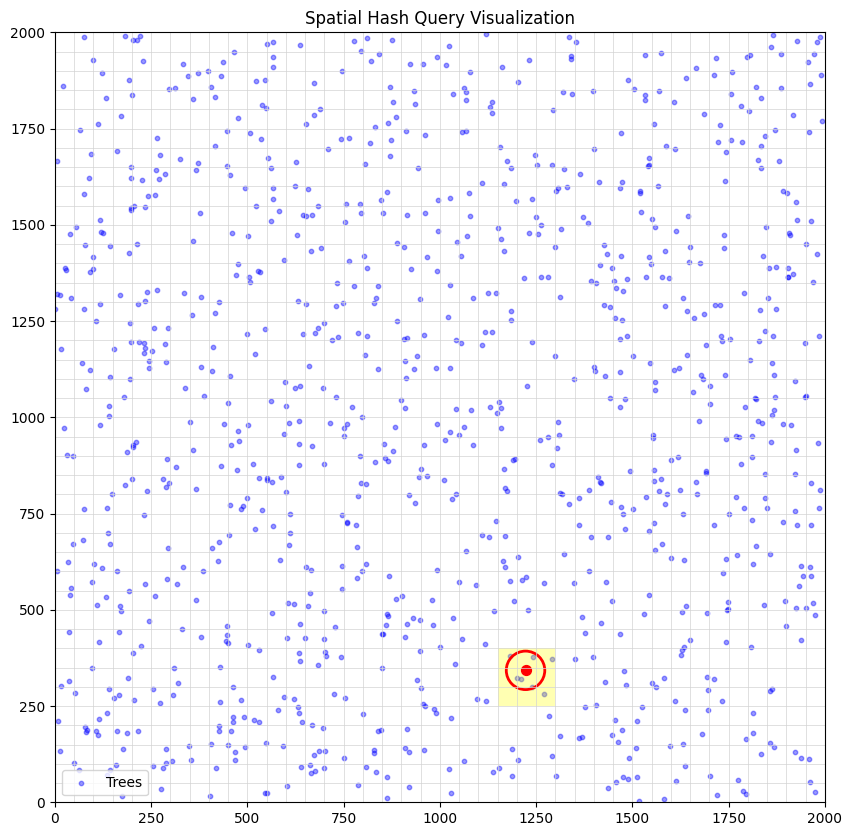

In [31]:
import matplotlib.pyplot as plt
import math



def plot_grid_query(grid, trees, query_x, query_y, radius, world_size=2000):
  cell = grid.cell_size
  num_cells = world_size // cell

  fig, ax = plt.subplots(figsize=(10,10))

  for i in range(num_cells + 1):
    ax.plot([i*cell,  i*cell],   [0,world_size],   color='lightgray',   linewidth=0.5)
    ax.plot([0, world_size],   [i*cell,  i*cell],   color='lightgray',   linewidth=0.5)



  xs = [t[1] for t in trees]
  ys = [t[2] for t in trees]

  ax.scatter(xs, ys,  s=10,  color='blue', alpha=0.4,  label='Trees')

  checked_cells = set(grid._query_cells(query_x,  query_y, radius))

  for (cx, cy) in checked_cells:
    rect = plt.Rectangle( (cx*cell, cy*cell),  cell, cell,  facecolor='yellow', alpha=0.3)
    ax.add_patch(rect)


  circle = plt.Circle( (query_x, query_y), radius, color='red',  fill=False, linewidth=2 )
  ax.add_patch(circle)



  ax.scatter( [query_x],  [query_y],  color='red',  s=50)

  ax.set_xlim(0, world_size)
  ax.set_ylim(0, world_size)
  ax.set_aspect('equal')
  ax.set_title('Spatial Hash Query Visualization')
  ax.legend()
  plt.show()




plot_grid_query(grid, trees, query_x, query_y, query_radius)



### Generate 50,000 random tree positions

In [32]:
import random

def generate_random_objects(n, world_size=2000):
  objects = []
  for i in range(n):
    x = random.uniform(0, world_size)
    y = random.uniform(0, world_size)
    objects.append( (i,x,y))

  return objects


In [33]:
N = 50_000
big_objects = generate_random_objects(N)

len(big_objects)

50000

In [34]:
cell_size = 50
grid_big = SpatialHashGrid(cell_size)

for obj, x, y in big_objects:
  grid_big.add_object( obj, x, y)


In [35]:
import time
import math

def naive_query(objects, qx, qy, radius):
  results = []
  r2 = radius * radius

  for obj,x,y in objects:
    if (x - qx)**2  + (y - qy)**2 <= r2:
      results.append(obj)

  return results




In [40]:
qx = random.uniform(0, 2000)
qy = random.uniform(0, 2000)

radius = 100


t0 = time.time()
res_naive = naive_query(big_objects, qx, qy, radius)
t1 = time.time()

print(f'Naive time: {t1-t0} seconds')
print(f'Found {len(res_naive)}')

t0_naive = t0
t1_naive = t1


Naive time: 0.012247562408447266 seconds
Found 429


### Time the grid-based search (fast)

In [41]:
t0 = time.time()
res_grid = grid_big.query_radius(qx, qy, radius)
t1 = time.time()

print(f'Grid time: {t1-t0} seconds')
print(f'Found {len(res_grid)}')

t0_grid = t0
t1_grid = t1



Grid time: 0.0009398460388183594 seconds
Found 429


##### Show speed-up factor

In [46]:
speed_up = (t1_naive- t0_naive) / (t1_grid - t0_grid)
print(f'Speed up: {speed_up:.2f} x faster')

Speed up: 13.03 x faster
